In [1]:
# %cd ".." - install dreye with pip install -e .

In [1]:
from dreye.estimators.dependent_excitation_models import DependentExcitationFit

In [2]:
import dreye
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [3]:
mspectra = dreye.create_measured_spectra_container(
    [340, 360, 400, 450, 505, 565, 620]
)
mspectra = dreye.create_measured_spectra_container(
    [340,  450, 565]
)

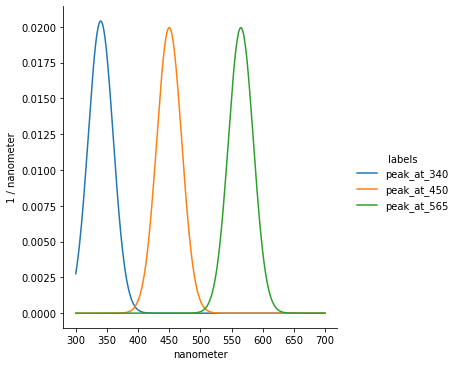

In [4]:
mspectra.normalized_spectra.plot()

In [5]:
mspectra.intensity_bounds

(array([0., 0., 0.]), array([100., 100., 100.]))

In [6]:
pr_model = dreye.create_photoreceptor_model(
    [360, 380, 430, 480, 550]
)
pr_model = dreye.create_photoreceptor_model(
    [360, 430, 550], 
#     photoreceptor_type='log', 
#     capture_noise_level=1e-4
)

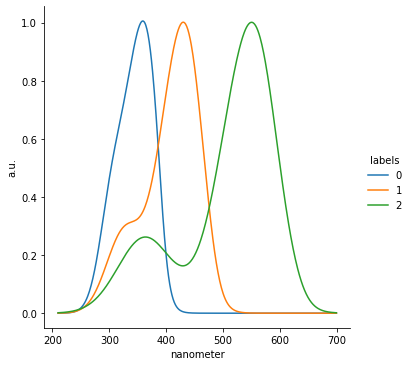

In [7]:
pr_model.sensitivity.plot()

In [8]:
# seed
rng = default_rng(14)

In [9]:
# model with all LEDs available in each subframe

In [10]:
layer_assignments = [
    [0, 2], [0, 1], [1, 2], [0, 1], [1, 2], [0, 1], [0, 2]
]

In [11]:
resolution = (64, 64)
n_subframes = len(layer_assignments)
bit_depth = 5
n_pixels = resolution[0] * resolution[1]

# random weights for leds
led_weights = rng.random(
    (len(mspectra), n_subframes)
) * 40
led_weights = np.zeros(
    (len(mspectra), n_subframes)
)
for idx, idcs in enumerate(layer_assignments):
    led_weights[idcs, idx] = rng.random(len(idcs)) * 40


# normalized capture matrix
A = pr_model.capture(
    mspectra.normalized_spectra, 
    return_units=False
)

pixel_strength = rng.random((n_pixels, n_subframes))
pixel_strength = pixel_strength / np.max(pixel_strength)
pixel_strength = (np.ceil(pixel_strength * 2**bit_depth) - 1) / (2**bit_depth - 1)

X = (pixel_strength @ led_weights.T) @ A
X = pr_model.excitefunc(X)

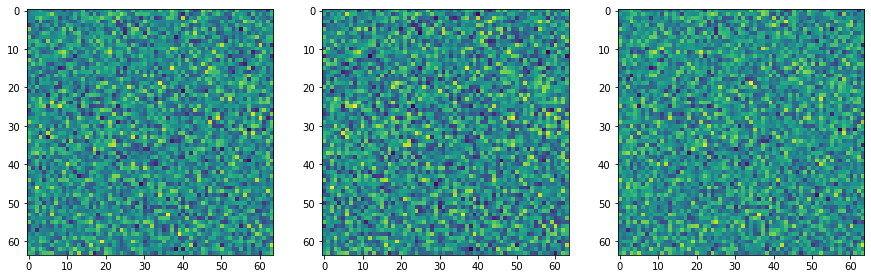

In [12]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(5 * X.shape[1], 5))
for idx, ix in enumerate(X.T):
    axes[idx].imshow(ix.reshape(resolution))

In [13]:
model = DependentExcitationFit(
    photoreceptor_model=pr_model,
    n_epochs=20,
    measured_spectra=mspectra,
    seed=11, 
    independent_layers=n_subframes, 
    bit_depth=bit_depth, 
    epoch_iter=5, 
    n_jobs=None,
    verbose=True, 
    layer_assignments=layer_assignments, 
    exploit=0.3, 
    n_exploit=5, 
    round_during_training=False, 
    normalize_during_training=False,
    sim=False, sample=0.1
#     ignore_bounds=True
)

In [14]:
import time

In [15]:
before = time.time()
model.fit(X)
after = time.time()

epochs: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]

`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 2.3415e+04, final cost 2.3132e+04, first-order optimality 3.65e-08.


In [16]:
model.score()

0.9870017101289514

In [45]:
model.feature_scores()

array([0.98968573, 0.99093041, 0.98947356])